# V1 Model with Cerebrum in Cybershuttle

# Introduction to Apache Cerebrum 

## Motivation

- Large public databases provide extensive and detailed maps of the brain (e.g. Brain Atlas) . 
- Using such atlases for the construction of computational models remains a challenge. 
- Diverse databases are required for construction of detailed models.
   - Spatial transcriptomics data allows for regional and layer-wise distributions of the different cell types. 
   - Synaptic physiology databases provide connection probabilities between the sets of neuron classes. 
- Data from diverse sources incorporated to construct detailed models 

## Cerebrum Goals 

- Flexible and extendable software that allows queries over different databases and brain atlases.
- Applies transformations such as maps and filters on the resultant data.
- Incorporate results within the computational models described using SONATA format


## Workflow Structure

Workflow to construct in Cerebrum follows the following steps: 

1. Extract data from experimental and brain atlas datasets via querying the  relevant databases. 
2. Map acquired data to regions of interest. 
3. Fill-in any missing details via an optional user-defined custom modifications. 
4. Realize the final network of neurons in SONATA format from the model recipe.

<div>
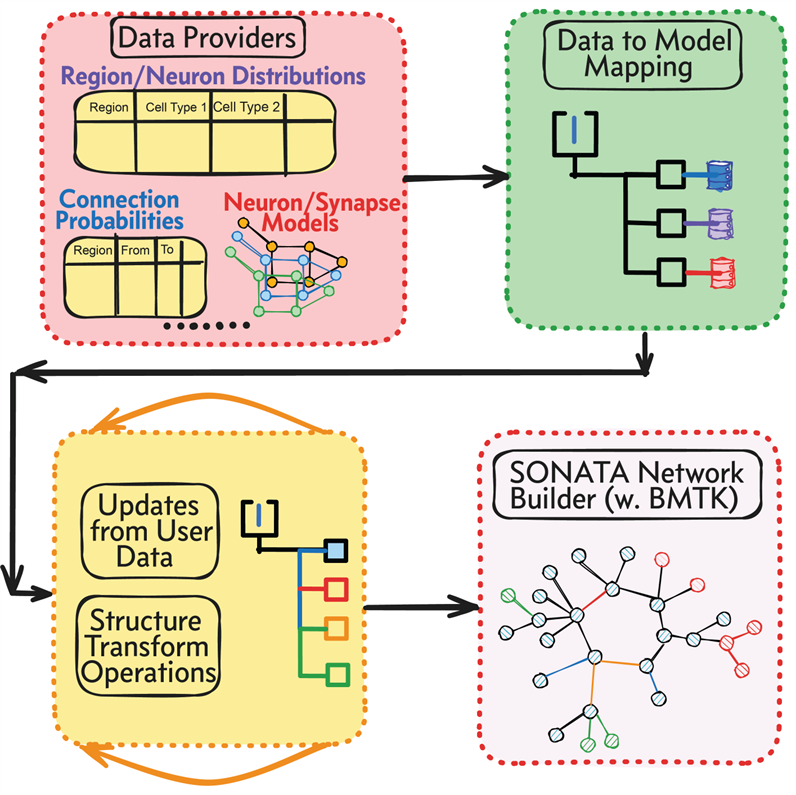
</div>

# Setup

## Perpare Runtime in Cybershuttle

* authentication
* starting up a runtime with N and X RAM and switching to it
* environment dependencies will be already installed here

In [ ]:
%pip install -qU "airavata-python-sdk[notebook]"
import airavata_jupyter_magic
 
%authenticate
%request_runtime hpc_cpu --file=cybershuttle.yml --walltime=60 --use=NeuroData25VC1:cloud
%wait_for_runtime hpc_cpu --live
%switch_runtime hpc_cpu

## Download Code and Data in Cybershuttle

In [ ]:
%%bash

git clone https://github.com/srirampc/airavata-cerebrum repo

ln -s repo/resources/notebooks/mousev1 mousev1
ln -s repo/resources/notebooks/v1 v1

In [ ]:
import logging
import pydantic
import nest
#
from pathlib import Path
#
import mousev1.model as v1model
import mousev1.operations as v1ops
from airavata_cerebrum.recipe import RecipeSetup, ModelRecipe
from airavata_cerebrum.model.structure import Network
from airavata_cerebrum.view.tree import DataSourceRecipeView, Data2ModelRecipeView, NetworkStructureView

# Model Recipe
Model Recipe defines key components for constructing a Model Network with Cerebrum. 

- **Data Providers:** Links to source database and query parameters
- **Filter and Transformers:** Filter via selection criteria on the queried data.
- **Data2Model Mappers:** Mapper methods that map data to model components.
- **User Modifications:** User Inputs that modify the data-derived model


<div>
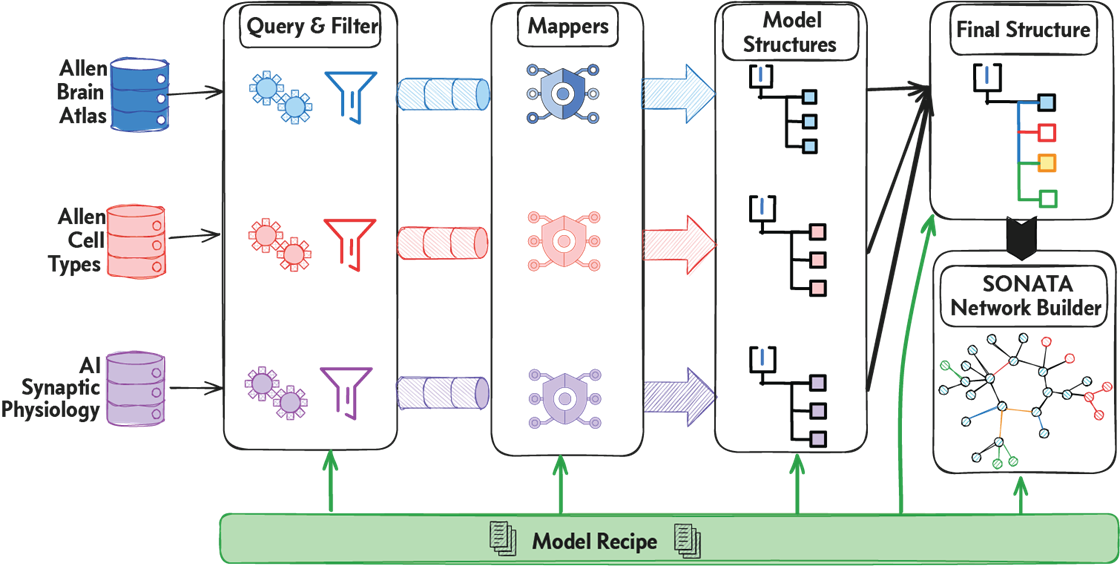
</div>

## V1 Model Recipe

Model recipe is defined by a collection of files under the recipe directory. Here, we use the directory `v1/recipe`, where `v1` is the base directory of the model.

Recipe json files contains three sections: 
1. **source_data section :** describes how the source databases are connected and different operations such as filters are applied to the data available from the specific database.
2. **data2model_map section :** data2model_map section describes how the source data is mapped to the different parts of the model.
3. **custom mod section :** describes the user modifications applied after a model skeleton is applied to the data.

The template file `recipe_template.json` used for rendering the repice as a tree structure in the notebook.

In [ ]:
class RcpSettings(pydantic.BaseModel):
    name: str = "v1"
    base_dir: Path = Path("./")
    recipe_dir: Path = Path("./v1/recipe/")
    levels: list[str] = ["L1",  "L23", "L4", "L5", "L6"]
    recipe_dm_levels: dict[str, str | Path] = {
        "L1"  : "recipe_dm_l1.json",
        "L23" : "recipe_dm_l23.json",
        "L4"  : "recipe_dm_l4.json",
        "L5"  : "recipe_dm_l5.json",
        "L6"  : "recipe_dm_l6.json",
    }
    custom_mod_levels: dict[str, str | Path] = {
        "L1"  : Path("./v1/recipe/custom_mod_l1.json"),
        "L23" : Path("./v1/recipe/custom_mod_l23.json"),
        "L4"  : Path("./v1/recipe/custom_mod_l4.json"),
        "L5"  : Path("./v1/recipe/custom_mod_l5.json"),
        "L6"  : Path("./v1/recipe/custom_mod_l6.json"),
    }
    ext_mods : list[str | Path] = [
        Path("./v1/recipe/custom_mod_ext.json"),
        Path("./v1/recipe/custom_mod_ext_lgn.json"),
        Path("./v1/recipe/custom_mod_ext_bkg.json"),
    ]
    ctdb_models_dir: Path = Path("./v1/components/point_neuron_models/")
    nest_models_dir: Path = Path("./v1/components/cell_models/")
    save_flag: bool = True

    @property
    def recipe_files(self) -> dict[str, list[str | Path]] :
        """The recipe_files property."""
        full_recipe = ["recipe.json", "recipe_data.json"] + [
            self.recipe_dm_levels[lx] for lx in self.levels
        ]
        return {
            "recipe": full_recipe,
            "templates": [ "recipe_template.json" ]
        }

    @property
    def custom_mod(self) -> list[str | Path] :
        return [
            Path("./v1/recipe/custom_mod.json"),
        ] + [
            self.custom_mod_levels[lx] for lx in self.levels
        ] + self.ext_mods


def recipe_setup(rcp_set: RcpSettings):
    return RecipeSetup(
        name=rcp_set.name,
        base_dir=rcp_set.base_dir,
        recipe_files=rcp_set.recipe_files,
        recipe_dir=rcp_set.recipe_dir,
        create_model_dir=True,
    )


rcp_set = RcpSettings()
md_recipe_setup = recipe_setup(rcp_set)
custom_mod_struct = Network.from_file_list(rcp_set.custom_mod)

# Source Data

Cerebrum defines multiple data provider modules. It includes
  - Methods for defining the querying from the database and filter the data based on specific criteria. 
  - Utilities to visualize the data provider configurations in easy-to-understand explorer view inside Jupyter notebook with the relevant parameters displayed in the side panel.

Construction of Mouse V1 is shown below with three different data providers: 
  - Allen Cell Types database,
  - Allen Brain Cell Atlas,
  - AI Synaptic Physiology Database, and
  - Gouwens et. al. (2019) neuron classification based on electrophysiolocial data.

In [ ]:
import IPython.display

IPython.display.JSON(md_recipe_setup.get_section('source_data'))

## Visualize Source Data

Using the templates we can view the links to the source data and the model with Jupter notebook widgets. 

<div>
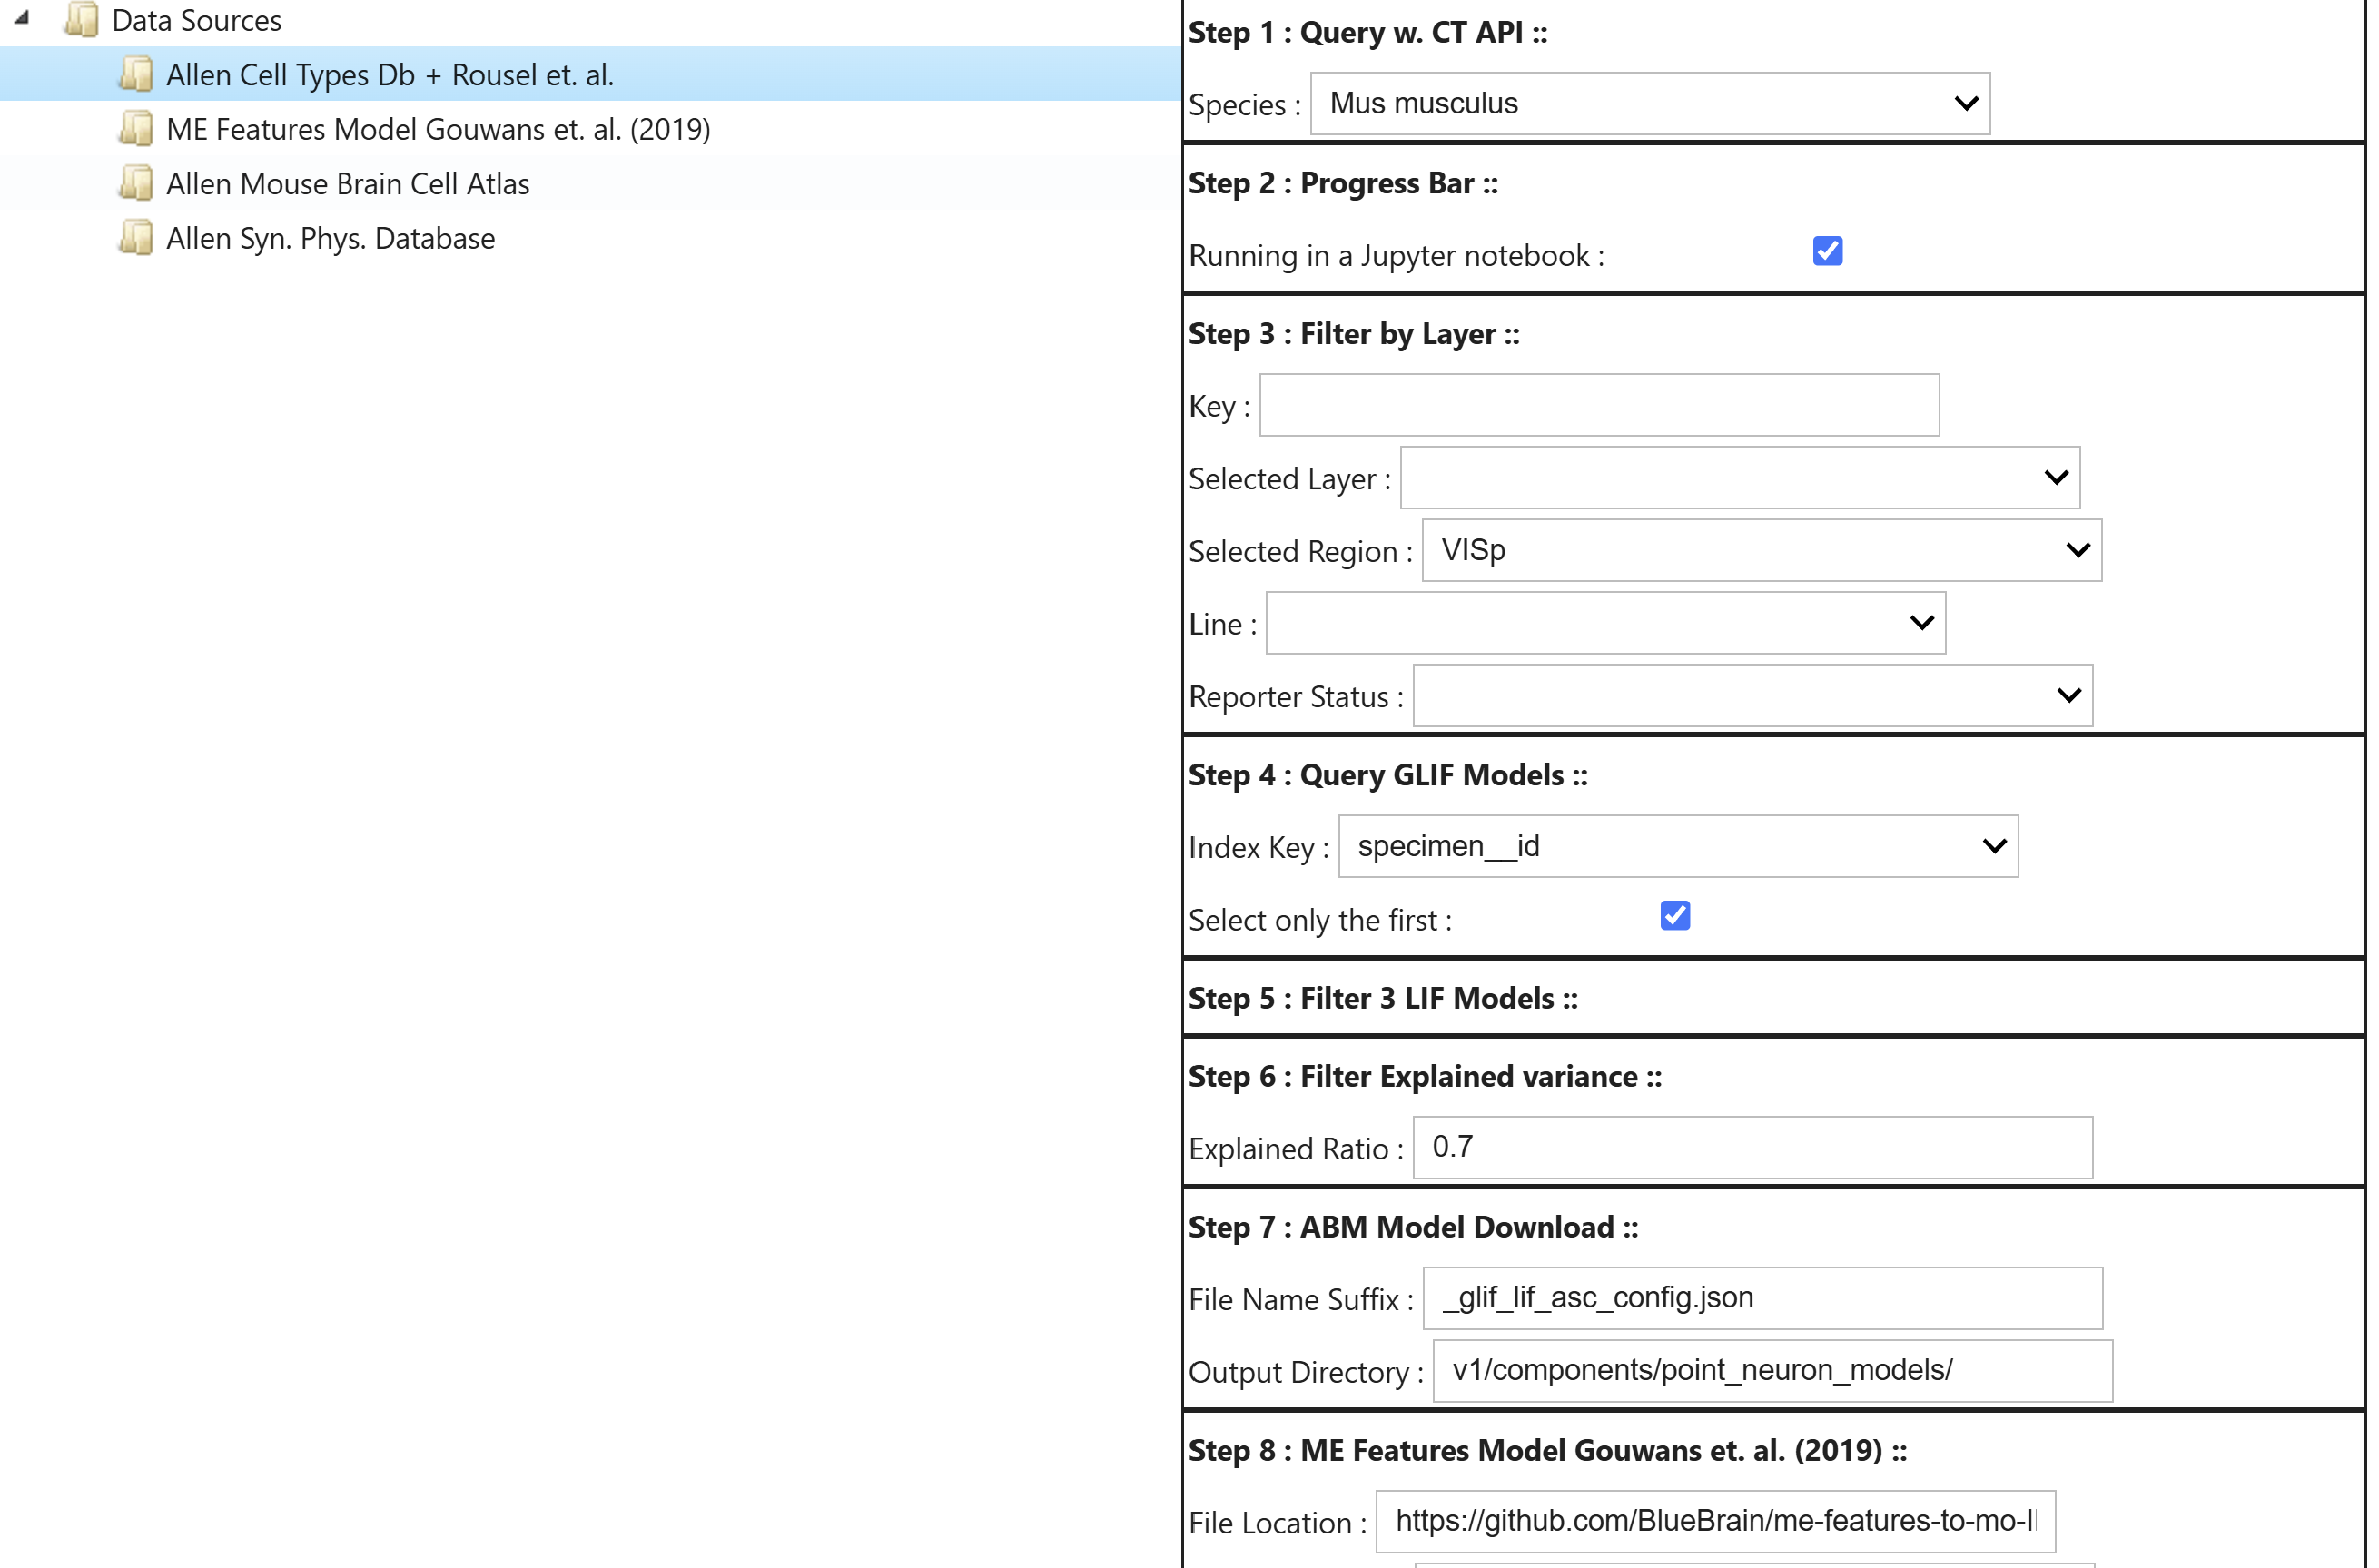
</div>

**NOT shown with Cybershuttle**

In [ ]:
sd_tree = DataSourceRecipeView(md_recipe_setup, left_width="55%")
sd_tree.build()
sd_tree.layout

# Data2Model Mapping

Definitions for data2model_map includes two parts:

1. *Locations:*
    - Locations are defined hiearchially with each section defining the data links.
    - For V1, data from Cell types database and the MERFISH atlas map to neuron models and the distribution of neuron types, respectively
    - For V1, we map eight different neuron types to the specific models and the region fractions. 
3. *Connections:*
    - Connections are defined as section for each pair to neuron sets, with each section defining the data links.
    - AI synaptic physiology data is mapped to the connection probabilities between the pairs of neuron classes.
    - For V1, we map each of the different neuron pairs to the AI Syn. Phys. Data outputs     

In [ ]:
import IPython.display

IPython.display.JSON(md_recipe_setup.get_section('data2model_map'))

### Visualize Data2Model Mapping
Using the templates we can view the links to the neuron pairs and the source data with Jupter notebook widgets.

<div>
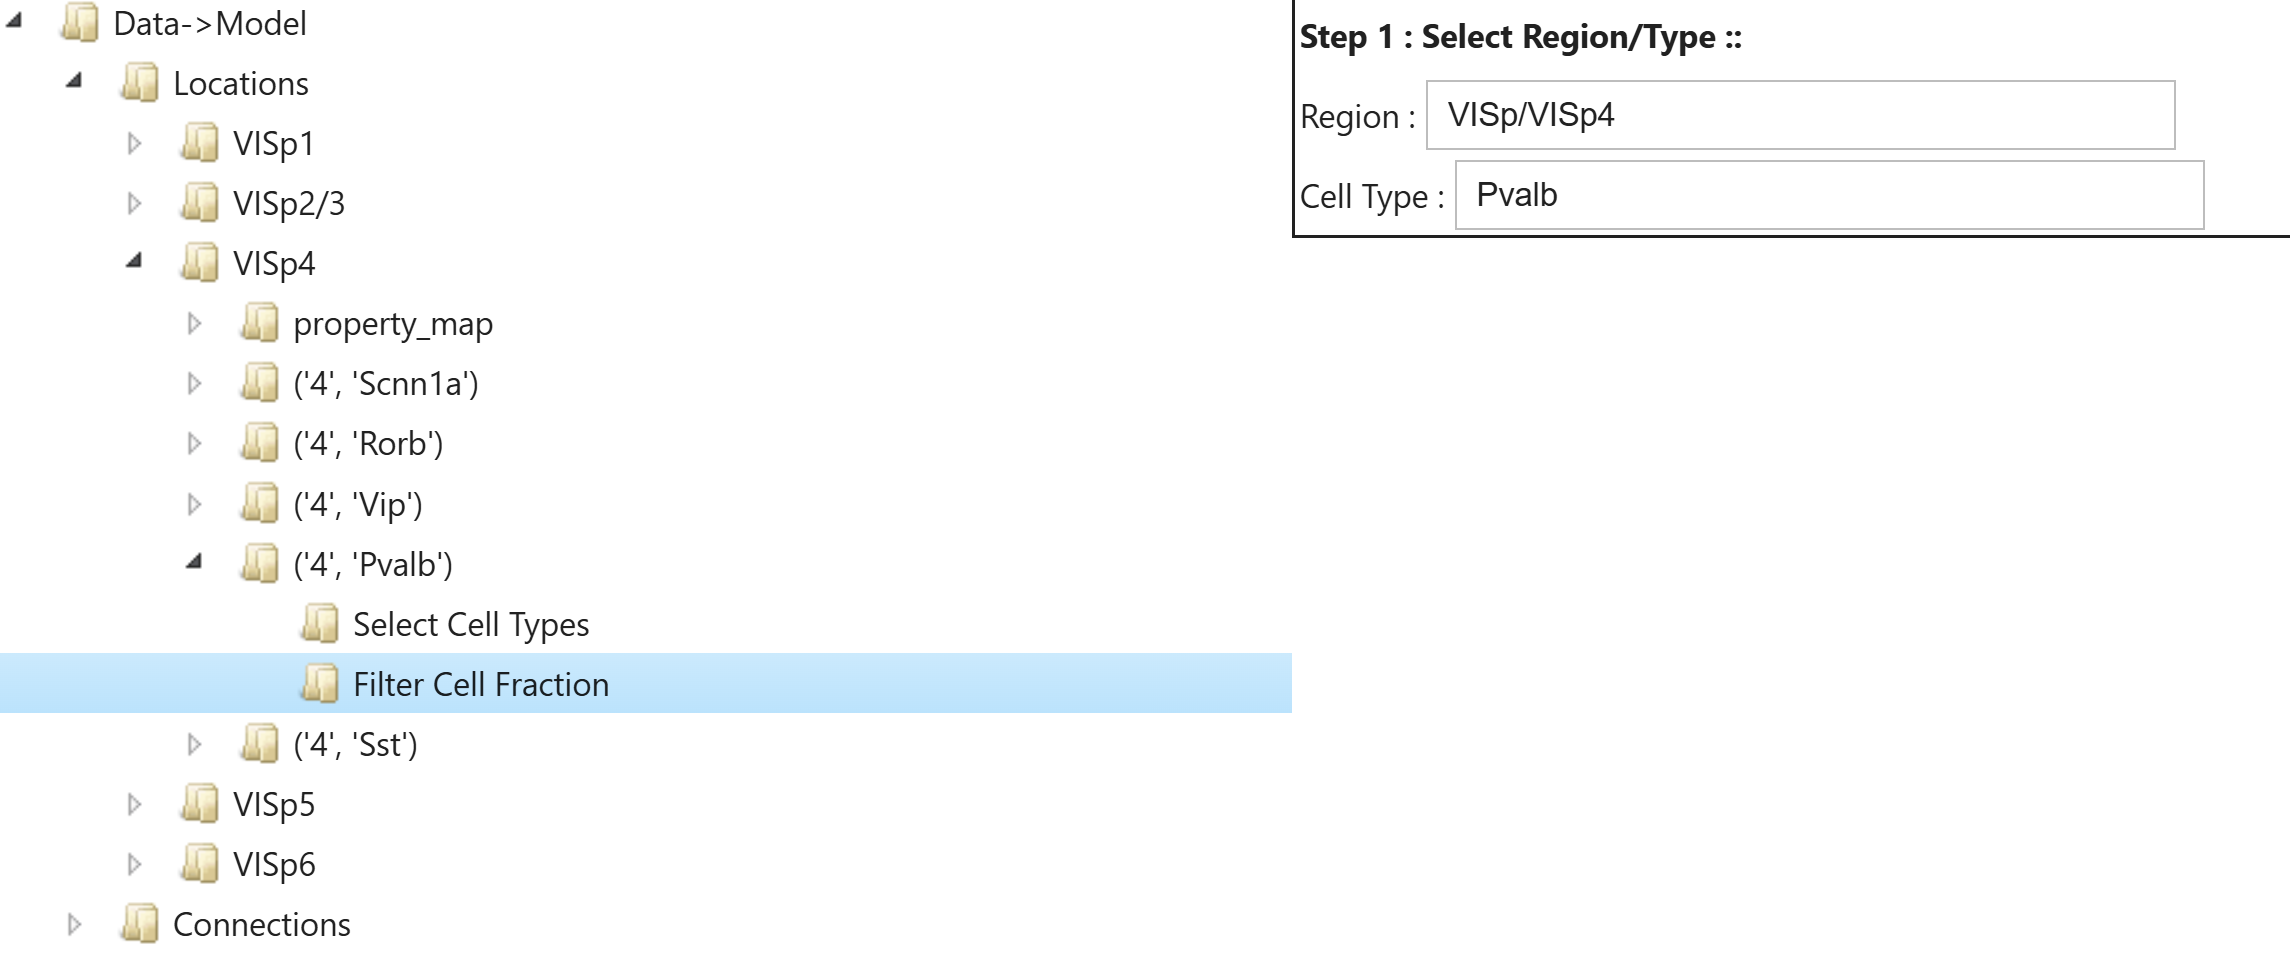
</div>

In [ ]:
dm_tree = Data2ModelRecipeView(md_recipe_setup, width="55%")
dm_tree.build()
dm_tree.layout

# Custom Modifications

Custom modifications to the data-driven model skeleton:
- Users can provide details required for network construction that are either not available in the linked databases or over-ride specific information.
- Utilities to visualize these modifications in Jupyter Notebook.

For the Mouse V1, custom modifications include 
1. Dimensions of each region in the model.
2. Connection Parameters not available with the AI Syn. Phys. database.
3. Details of the networks that are external to V1 : LGN and the background networks. 


In [ ]:
import IPython.display

IPython.display.JSON(custom_mod_struct.model_dump())

### Visualize Custom Mod structure

Using the templates we can view the user custom modifications with Jupter notebook widgets. 

**Due to Size Restrictions, this doesn't work in ipython for now**

In [ ]:
cmod_view = cbm_tree.NetworkStructureView(custom_mod_struct, left_width="55%")
cmod_view.build()
cmod_view.layout

# Mappers for SONATA Network
To realize model recipe to SONATA Network, define three python classes

1. *Region Mapper* : Maps the location details to a region in the network.
2. *Neuron Mapper* : Map the neuron details within in a location to a neuron class within the region.
3. *Connection Mapper*: Map the connection data to a connection object in the network of neurons.

In addition a *Network Builder* class is also defined that translates the model description to SONATA network. 

In [ ]:
model_recipe = ModelRecipe(
    recipe_setup=md_recipe_setup,
    region_mapper=v1model.V1RegionMapper,
    neuron_mapper=v1model.V1NeuronMapper,
    connection_mapper=v1model.V1ConnectionMapper,
    network_builder=v1model.V1BMTKNetworkBuilder,
    mod_structure=custom_mod_struct,
    save_flag=rcp_set.save_flag,
)
# logging.basicConfig(level=logging.INFO)

# Data Acquistition

Data acquisition consists of the following two steps:

## Run Data Download Workflow

After the model description is defined and updated with custom user modifications, the download workflow proceeds as follows:
1. Query and download the data from different databases of interest.
2. Apply the filters and transormations.
3. Save downloaded data to a local database.

## Run Download Post Operations

After data is dowloaded, the data obtained from different databases need to processed separately:

1.  In case of the Allen Cell Type database, the download step can be restricted only to obtain the metadata related to cell types. After the meta data is downloaded, we need to acquire the models of interest (3 LIF Models). We use the GLIF API from allensdk to download these 3LIF model with a explained variance threshold. Further filter is applied based on the classification by *Gouwens et. al. (2019)*.
2.  For data from Allen Brain Cell Atlas, we filter the data specific to only the VISp region.
3.  For AI Syn Phys. data, we select only the neuron pairs of our interest.

We accomplish the above two steps by running `recipe.acquire_source_data()` function.

In [ ]:
db_source_data = model_recipe.acquire_source_data()

# Explore downloaded data

Output data are stored in the description directory in json format `(db_connect_output.json)`, which can be examine with json library. Here are examples of Region and Neuron fractions of the Allen Brain Atlas, and connectivity matrix downloaded from AI Syn. Phys. dataset. 

Output data is also stored as duckdb database `db_connect_output.db`, which can be used for more detailed queries.

In [ ]:
import json
#
with open("./v1/recipe/db_connect_output.json") as dbf:
    db_out_data = json.load(dbf)

In [ ]:
import airavata_cerebrum.dataset.abc_mouse as abcm
abcm.DFBuilder.build(db_out_data['airavata_cerebrum.dataset.abc_mouse'])

In [ ]:
import airavata_cerebrum.dataset.ai_synphys as aisp
aisp.DFBuilder.build(db_out_data['airavata_cerebrum.dataset.ai_synphys'])

In [ ]:
import airavata_cerebrum.dataset.me_features as meft
meft.DFBuilder.build(db_out_data['airavata_cerebrum.dataset.me_features'])

# Map Source data to Model

In this step, the data downloaded is mapped to the locations and the connection pairs as mentioned in "Data2Model Map" section above.


In [ ]:
logging.basicConfig(level=logging.INFO)
#
msrc = model_recipe.map_source_data()

# Build Data-drivern Model Skeleton

A base skeleton of the model is constructed based on the database.

In [ ]:
msrc = model_recipe.build_net_struct()

Snapshot showing the Fraction obtained from the merfish database :

<div>
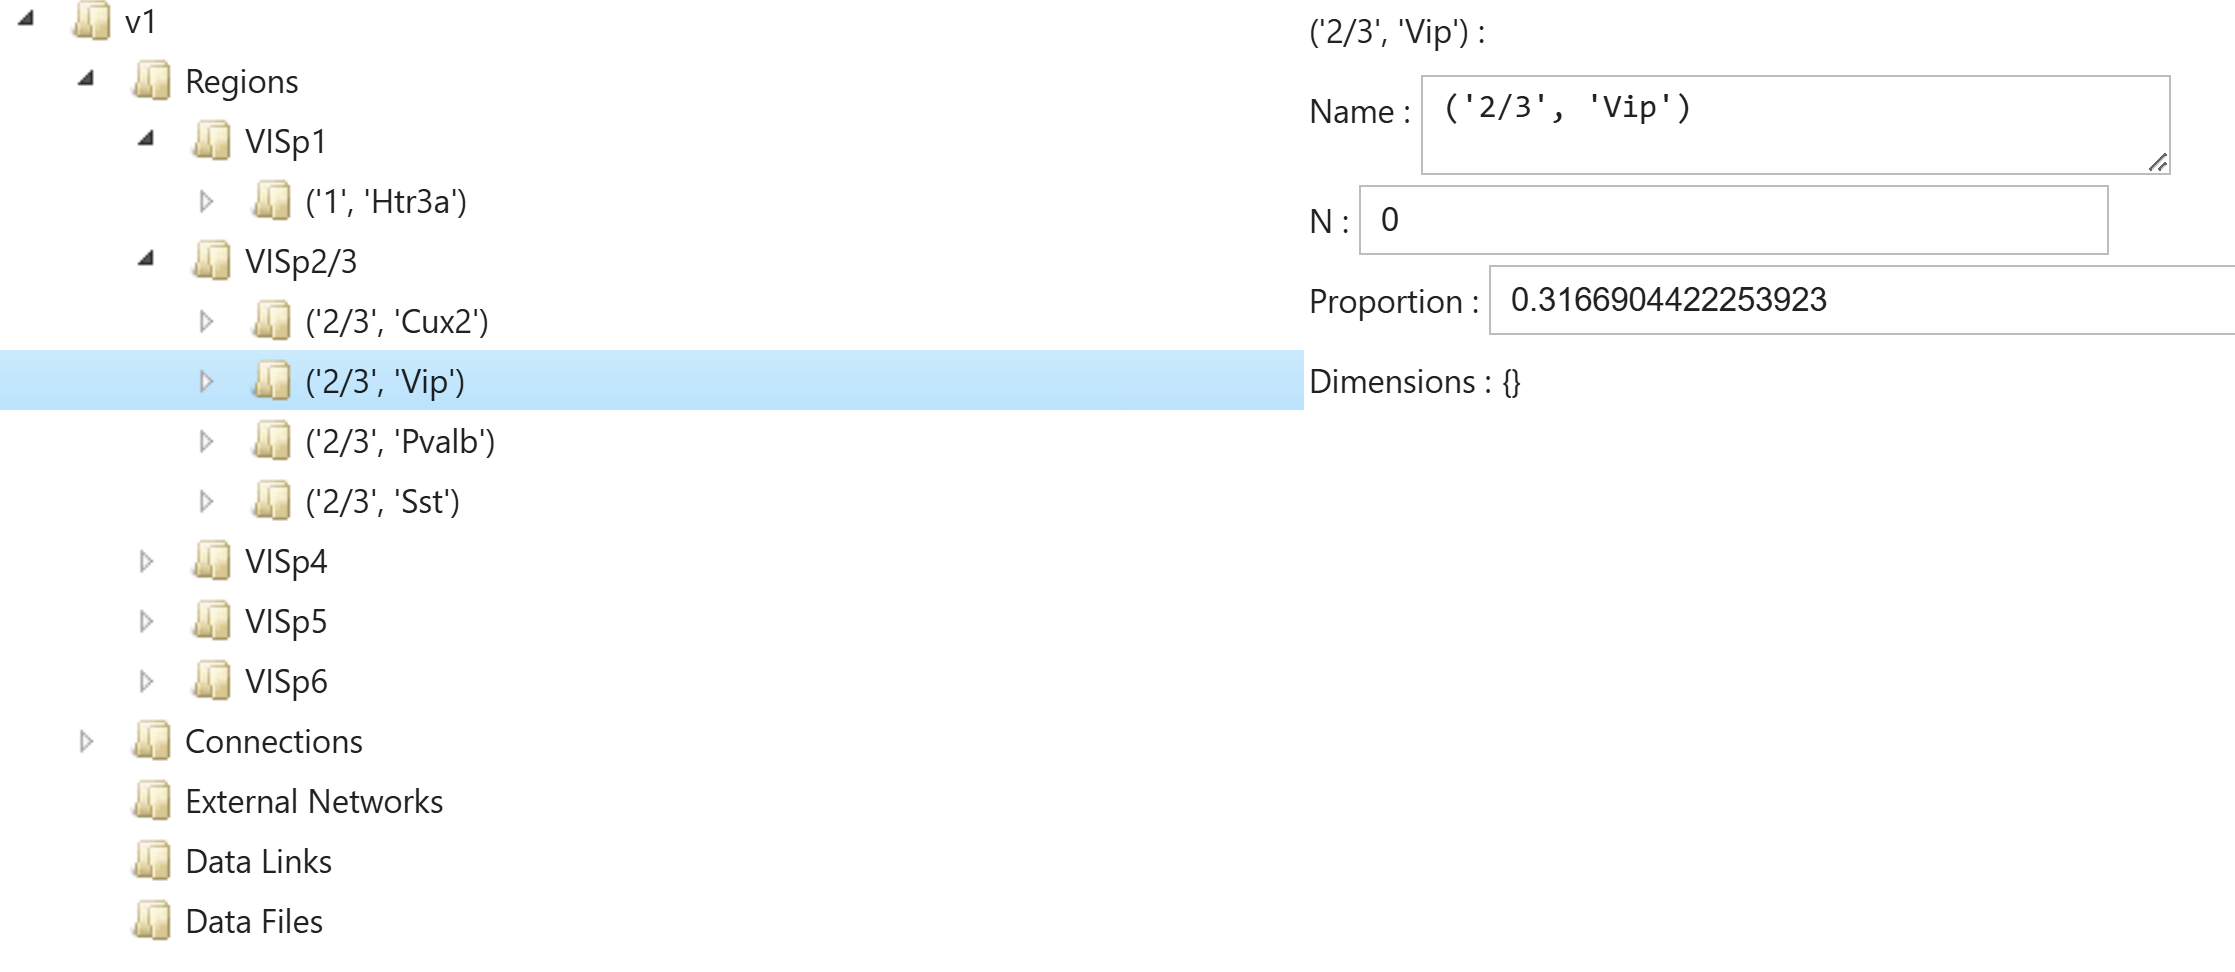
</div>

In [ ]:
nv_tree = NetworkStructureView(msrc).build()
nv_tree.layout

# Apply Custom Modification
As mentioned in the "Custom Modifications" section above, user updates for the model are loaded from `./v1/description/custom_mod.json`.

For V1, the user modification include dimension, additional connection properties, and properties of external netowrks

In [ ]:
msrc = model_recipe.apply_mod(ncells=30000)

In [ ]:
IPython.display.JSON(msrc.model_dump())

# Build SONATA Network with BMTK

In [ ]:
import mousev1.model as v1model
bmtk_net_builder = v1model.V1BMTKNetworkBuilder(model_recipe.network_struct)
bmtk_net = bmtk_net_builder.build()

## Save SONATA

Save SONATA with BMTK

**Skipping Save SONTA as it takes a long time (files are make available in v1/ folder)** 

In [ ]:
bmtk_net_builder.net.save(str(md_recipe_setup.network_dir))
bmtk_net_builder.bkg_net.save(str(md_recipe_setup.network_dir))

# Update/Change of the Model

1. Directly Update the json to add update queries/parameters
2. Load parts of json by splitting into differnet files
3. Custom query classes by subclassing DBQuery.
4. Custom mapper functions by subclassing OpXformer.
5. Custom SONATA network builder classes.

In [ ]:
def data_mapped_model(levels: tuple[str,...]=("L1", "L23", "L4")):
    mdrcp = model_recipe(RcpSettings(levels=list(levels)))
    mdrcp.map_source_data()
    mdrcp.build_net_struct()
    mdrcp.apply_mod()
    mdrcp.build_network()

data_mapped_model(("L4"))

# Post Processing
## Convert downloaded models to NEST confirmed models

The format of the glif properties json files present  in the cell types database

**Skipping Save NEST model files as it takes a long time (files are make available in v1/ folder)** 

In [ ]:
# Converting to 
import mousev1.operations as mousev1ops
import nest
import matplotlib.pyplot as plt

mousev1ops.convert_ctdb_models_to_nest(
    "./v1/components/point_neuron_models/",
    "./v1/components/cell_models/"
)


# SONATA Network in NEST


In [ ]:
from typing import NamedTuple
#
from nest.lib.hl_api_sonata import SonataNetwork
from nest.lib.hl_api_nodes import Create as NestCreate
from nest.lib.hl_api_connections import Connect as NestConnect
from nest.lib.hl_api_types import NodeCollection

class NestSonata(NamedTuple):
    net : SonataNetwork | None = None
    spike_rec: NodeCollection | None = None
    multi_meter: NodeCollection | None = None

def load_nest_sonata(
    nest_config_file: str = "./v1/config_nest.json",
):
    # Instantiate SonataNetwork
    sonata_net = SonataNetwork(nest_config_file)

    # Create and connect nodes
    node_collections = sonata_net.BuildNetwork()
    print("Node Collections", node_collections.keys())

    # Connect spike recorder to a population
    spike_rec = NestCreate("spike_recorder")
    NestConnect(node_collections["v1"], spike_rec)

    # Attach Multimeter
    multi_meter = NestCreate(
        "multimeter",
        params={
            # "interval": 0.05,
            "record_from": [
                "V_m",
                "I",
                "I_syn",
                "threshold",
                "threshold_spike",
                "threshold_voltage",
                "ASCurrents_sum",
            ],
        },
    )
    NestConnect(multi_meter, node_collections["v1"])

    # Simulate the network
    # sonata_net.Simulate()
    return NestSonata(sonata_net, spike_rec, multi_meter)

nest_net = load_nest_sonata()

In [ ]:
nest_net.net.Simulate()

In [ ]:
dmm = nest_net.multi_meter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
#
plt.figure(1)
plt.plot(ts, Vms)

In [ ]:
spike_data = nest_net.spike_rec.events
spike_senders = spike_data["senders"]
ts = spike_data["times"]
plt.figure(2)
plt.plot(ts, spike_senders, ".")
plt.show()